# Building a CNN for classifying real-world images

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torchsummary

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data_dir = '/home/lacie/Data/image_transfer/dogs-vs-cats/train'
test_data_dir = '/home/lacie/Data/image_transfer/dogs-vs-cats/test'

In [3]:
from torch.utils.data import DataLoader, Dataset
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [4]:
data = cats_dogs(train_data_dir)
im, label = data[200]

In [5]:
len(data)

25000

tensor([0.], device='cuda:0')


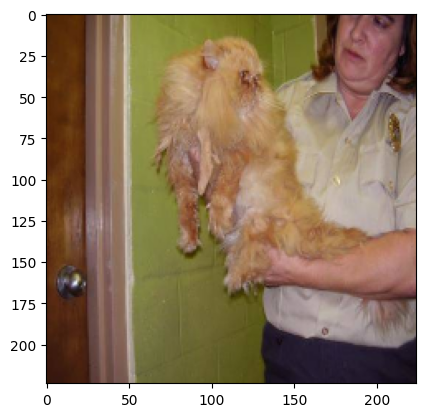

In [6]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [7]:
def conv_layer(ni,no,kernel_size,stride=1):
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
    )
def get_model():
    model = nn.Sequential(
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [8]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [10]:
def get_data():     
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [11]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [12]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
1

1

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


In [ ]:
len(train_epoch_accuracies)

8000

In [ ]:
len(train_epoch_accuracies[0])

1

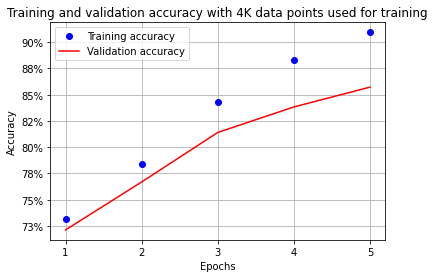

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_1k = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies_1k.append(val_epoch_accuracy)

0
1
2
3
4


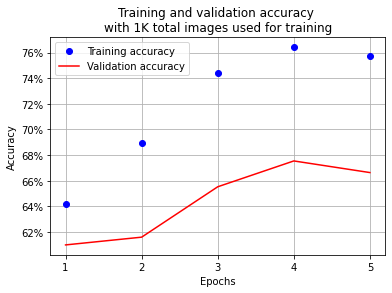

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_1k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 1K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:1000] + dogs[:1000]
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_2k = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies_2k.append(val_epoch_accuracy)

0
1
2
3
4


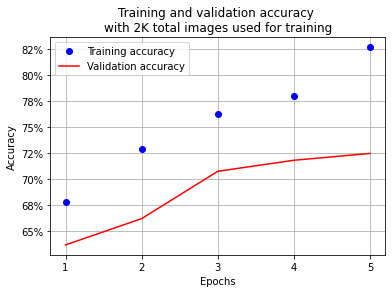

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_2k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 2K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:2000] + dogs[:2000]
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dog=1 & cat=0
  def __len__(self): return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_4k = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies_4k.append(val_epoch_accuracy)

0
1
2
3
4


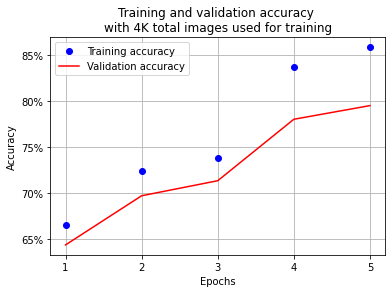

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies_4k, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \nwith 4K total images used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

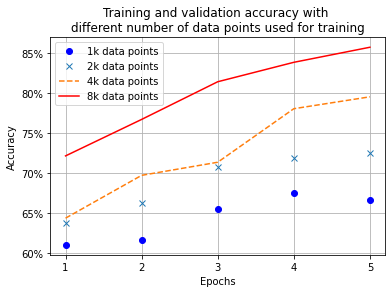

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.plot(epochs, val_accuracies_1k, 'bo', label='1k data points')
plt.plot(epochs, val_accuracies_2k, 'x', label='2k data points')
plt.plot(epochs, val_accuracies_4k, '--', label='4k data points',markersize = 20)
plt.plot(epochs, val_accuracies, 'r', label='8k data points')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with \ndifferent number of data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()